In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/long/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df = pd.read_csv('paris_temperature.csv')

In [3]:
df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Paris,France",2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,...,3.5,3,10,2023-10-01T07:49:34,2023-10-01T19:30:27,0.57,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,0715709999..."
1,"Paris,France",2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,...,4.4,4,10,2023-10-02T07:51:01,2023-10-02T19:28:21,0.60,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0715709999..."
2,"Paris,France",2023-10-03,22.1,15.0,18.8,22.1,15.0,18.8,13.0,69.9,...,4.8,4,10,2023-10-03T07:52:29,2023-10-03T19:26:16,0.63,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,"07149099999,07156099999,07146099999,LFPV,07157..."
3,"Paris,France",2023-10-04,18.2,10.2,14.2,18.2,10.2,14.2,9.3,73.2,...,5.1,4,10,2023-10-04T07:53:57,2023-10-04T19:24:10,0.66,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."
4,"Paris,France",2023-10-05,19.8,11.0,14.7,19.8,11.0,14.7,9.4,72.1,...,3.5,3,10,2023-10-05T07:55:25,2023-10-05T19:22:06,0.70,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."


In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Question 1

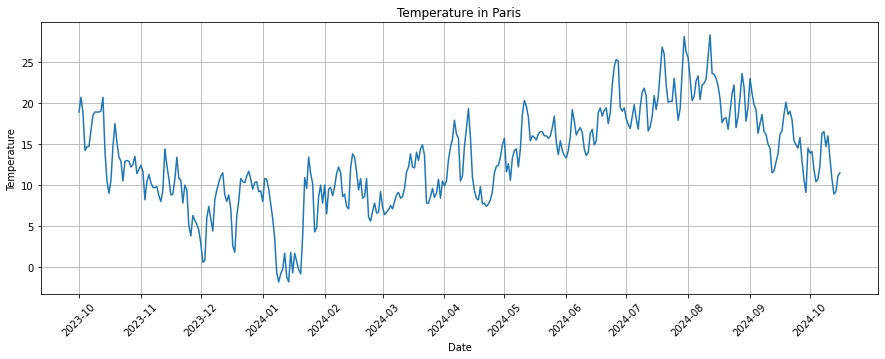

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['temp'])
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.show()

# Question 2

| **Feature**              | **Meaning**                                                                                                   | **Values**                                                |
|--------------------------|---------------------------------------------------------------------------------------------------------------|----------------------------------------------------------|
| `name`                   | The location of the recorded weather                                                                          | All are "Paris,France"                                  |
| `datetime`               | The date (without time) of the recorded weather in ISO 8601 format (YYYY-MM-DD)                            | Ranging from October 1st 2023 to October 16th 2024      |
| `tempmax`                | The maximum recorded temperature                                                                               | From -1.3 to 36.2, recorded in degree Celsius           |
| `tempmin`                | The minimum recorded temperature                                                                               | From -4.1 to 21.2, recorded in degree Celsius           |
| `temp`                   | The average temperature of the day                                                                             | From -1.8 to 28.3, recorded in degree Celsius           |
| `feelslikemax`          | The maximum "feels like" temperature of the recorded day                                                      | From -5.5 to 39.0, recorded in degree Celsius           |
| `feelslikemin`          | The minimum "feels like" temperature of the recorded day                                                      | From -7.3 to 21.2, recorded in degree Celsius           |
| `feelslike`              | The average "feels like" temperature of the recorded day                                                     | From -6.3 to 29.6, recorded in degree Celsius           |
| `dew`                    | The atmospheric temperature below which water droplets begin to condense                                      | From -6.1 to 20.3, recorded in degree Celsius           |
| `humidity`               | A quantity representing the amount of water vapor in the atmosphere                                            | From 51.6% to 95.0%                                     |
| `precip`                 | The amount of water falling from the sky (rain, drizzle, snow, sleet, hail, etc.)                           | From 0.0 to 25.008, recorded in millimeters             |
| `precipprob`             | The probability of precipitation occurring (possibly recorded after precipitation occurred)                    | 0 if no precipitation, 100 otherwise                     |
| `precipcover`            | The percentage of the area that received precipitation                                                         | 0 if no precipitation; 3.2% to 100% for others           |
| `preciptype`             | The type of precipitation                                                                                      | Empty for no precipitation; possible values: "rain", "rain,snow", or "rain,freezingrain,snow" |
| `snow`                   | The amount of snow recorded                                                                                   | 0 for days without snow; 0.1 to 5.4 recorded in mm      |
| `snowdepth`              | The depth of snow on the ground                                                                                | 0 for most days without snow; 0.1 to 3.9 recorded in mm  |
| `windgust`               | The maximum wind gust speed recorded                                                                            | From 14.4 to 92.2, unknown unit                          |
| `windspeed`              | The average sustained wind speed recorded                                                                      | From 6.8 to 44.3, unknown unit                           |
| `winddir`                | The direction of the wind                                                                                     | In compass degrees (0-360)                               |
| `sealevelpressure`       | The atmospheric pressure at mean sea level                                                                     | From 979.7 to 1042.8, unknown unit                       |
| `cloudcover`             | The percentage of cloud cover                                                                                  | From 13.0% to 100.0%                                    |
| `visibility`             | The measure of the distance at which an object or light can be clearly discerned                                | From 5.1 to 39.1, unknown unit                           |
| `solarradiation`         | The recorded value of solar radiation                                                                           | From 0.0 to 169.8                                       |
| `solarenergy`            | The total energy released from the sun that is absorbed in the recorded area                                   | From 0.0 to 14.7                                        |
| `uvindex`                | The UV index indicating the strength of ultraviolet radiation from the sun                                     | Integer values from 0 to 8                               |
| `severerisk`             | A risk rating indicating the severity of weather conditions                                                    | All entries have the value of 10                         |
| `sunrise`                | The time of sunrise                                                                                           | Recorded in ISO 8601 format (YYYY-MM-DDThh:mm:ss)       |
| `sunset`                 | The time of sunset                                                                                            | Recorded in ISO 8601 format (YYYY-MM-DDThh:mm:ss)       |
| `moonphase`              | The shape of the visible moon (moon phase)                                                                    | Ratio of visible moon area; 0 for new moon, 1 for full moon |
| `conditions`             | A summary of the weather conditions                                                                           | Contains type(s) of precipitation and cloud amount       |
| `description`            | A detailed description of the daily weather                                                                    | Text describing the weather of the recorded day          |
| `icon`                   | An icon representing the dominant weather conditions                                                          | String that indicates the weather type                   |
| `stations`               | A list of weather stations that provided the data                                                             | CSV list of strings identifying the stations              |

# Question 3

In [6]:
numerical_features = []
categorical_features = []
date_features = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        numerical_features.append(col)
    elif df[col].dtype == 'object':
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"There are {len(numerical_features)} numerical features: {numerical_features}")
print(f"There are {len(categorical_features)} categorical features: {categorical_features}")

There are 24 numerical features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
There are 8 categorical features: ['name', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations']


In [7]:
df_numerical = df[numerical_features]
df_numerical.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,0.144,100.0,...,11.3,170.2,1023.7,46.5,18.6,39.8,3.5,3,10,0.57
2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,0.000,0.0,...,12.0,173.7,1018.8,48.6,16.8,51.3,4.4,4,10,0.60
2023-10-03,22.1,15.0,18.8,22.1,15.0,18.8,13.0,69.9,0.386,100.0,...,22.8,277.2,1020.5,71.8,22.1,54.5,4.8,4,10,0.63
2023-10-04,18.2,10.2,14.2,18.2,10.2,14.2,9.3,73.2,0.006,100.0,...,12.3,260.9,1029.8,62.0,22.4,58.9,5.1,4,10,0.66
2023-10-05,19.8,11.0,14.7,19.8,11.0,14.7,9.4,72.1,0.014,100.0,...,6.8,238.3,1027.3,82.3,21.3,41.7,3.5,3,10,0.70


# Question 4

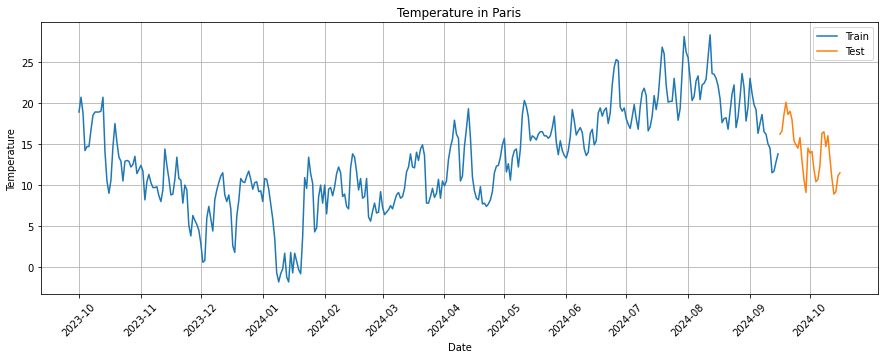

X_train shape: (351, 23), y_train shape: (351,)
X_test shape: (31, 23), y_test shape: (31,)


In [8]:
train_set = df_numerical[df_numerical.index <= pd.Timestamp('2024-09-15')]
test_set = df_numerical[df_numerical.index > pd.Timestamp('2024-09-15')]
plt.figure(figsize=(15, 5))
plt.plot(train_set.index, train_set['temp'], label='Train')
plt.plot(test_set.index, test_set['temp'], label='Test')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df_numerical.index.min(), end=df_numerical.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df_numerical.index.min(), end=df_numerical.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.legend()
plt.show()

X = df_numerical[['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 
                  'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 
                  'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 
                  'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 
                  'uvindex', 'severerisk', 'moonphase']].values

y = df_numerical['temp'].values

train_len = len(train_set)
X_train = X[:train_len]
X_test = X[train_len:]
y_train = y[:train_len]
y_test = y[train_len:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


## Part a
### Definition and Formulas

The ARIMA model is a combination of AR and MA models, with an added component for handling non-stationary data through differencing. The model is represented as $ARIMA(p, d, q)$, where:

* $p$ is the order of the AR part,
* $d$ is the number of differencing operations to make the series stationary,
* $q$ is the order of the MA part.

An ARIMA model first applies differencing $d$ times to the time series and then fits an ARMA model (combination of AR and MA) on the differenced data.

For example, if the differenced series is denoted by $X'_t$​, the ARIMA model can be written as:
$$ X'_t = c + \sum_{i=1}^p \phi_i X'_{t-i} + \sum_{i=1}^q \theta_i \varepsilon_{t-i} + \varepsilon_t.$$

Steps for Applying ARIMA:

* Differencing: If the original time series is non-stationary, apply differencing until the series becomes stationary. This removes trends and makes the series more stable.
* Fit $AR(p)$ and $MA(q)$: After differencing, apply an AR and MA model to the stationary series, with orders determined by analyzing autocorrelation and partial autocorrelation plots.
* Estimate Parameters: Use statistical techniques to estimate the model parameters.

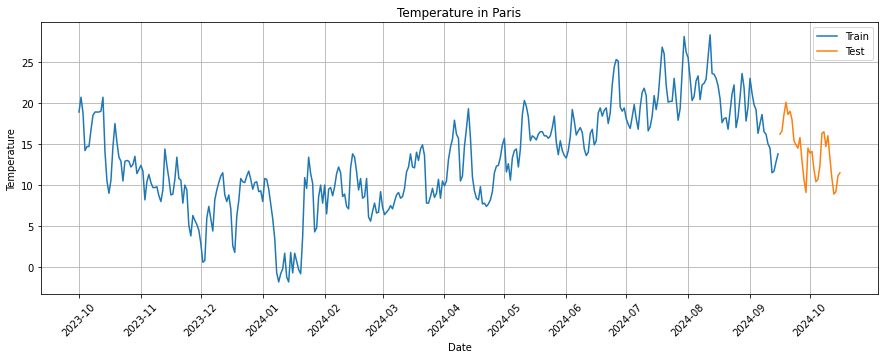

In [9]:
target = df['temp']
train = target['2023-10-01':'2024-09-15'] 
test = target['2024-09-16':]
plt.figure(figsize=(15, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.legend()
plt.show()

### Determine differencing order
#### Definition

The Augmented Dickey-Fuller (ADF) test is used to determine whether a time series is stationary. The mathematical representation of the ADF test involves estimating the following regression:

1. Formula:

$$ \Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \delta_2 \Delta y_{t-2} + \ldots + \delta_p \Delta y_{t-p} + \epsilon_t.$$

$$\begin{align*}
&\text{Where:} \\
&\Delta y_t : \text{The first difference of the series } y_t \text{ (i.e., } y_t - y_{t-1} \text{).} \\
&\alpha : \text{A constant (intercept) term.} \\
&\beta t : \text{A linear trend term.} \\
&\gamma : \text{The coefficient that is being tested to determine if } y_t \text{ is stationary.} \\
&\delta_i : \text{Coefficients of the lagged difference terms.} \\
&p : \text{The number of lagged difference terms included in the model (lags of the first difference).} \\
&\epsilon_t : \text{The error term.}
\end{align*}.$$

2. Key Points:
* Null Hypothesis ($H_0$): The time series has a unit root (i.e., it is non-stationary).
* Alternative Hypothesis ($H_1$): The time series is stationary.

#### Applying Code
Using ndiffs function

In [10]:
from pmdarima.arima.utils import ndiffs
ndiffs(target, test='adf')

1

The test returns 1, so we need to use 1st order differencing

In [11]:
temp_diff = target.diff().dropna()
ndiffs(temp_diff, test='adf')

0

The test resulting 0 means now the dataset is suitable for implementing to model

Using adfuller to elaborate more on stationary status

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(target) 
print('ADF Statistic:', result[0]) 
print('p-value:', result[1]) 
print('Critical Values:') 
for key, value in result[4].items(): 
    print(f'\t{key}: {value:.3f}')

ADF Statistic: -2.742622887630039
p-value: 0.06694856335880962
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


The p-value is greater than 0.05. This mean that the data is not stationary so we apply the first diff for this one

In [13]:
if result[1] > 0.05: 
    data_diff = target.diff().dropna()
    result_diff = adfuller(data_diff) 
    print('ADF Statistic (1st diff):', result_diff[0]) 
    print('p-value (1st diff):', result_diff[1]) 
    print('Critical Values (1st diff):') 
    for key, value in result_diff[4].items(): 
        print(f'\t{key}: {value:.3f}')

ADF Statistic (1st diff): -14.794239815296413
p-value (1st diff): 2.1478107704103312e-27
Critical Values (1st diff):
	1%: -3.448
	5%: -2.869
	10%: -2.571


The p-value now is signifincantly lower that 0.05 and it's considered stationary so we go to the next step

### Apply ARIMA

In [14]:
# Using auto_arima
from pmdarima import auto_arima
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error,r2_score

arima_model = auto_arima(train,
                      start_p=0, max_p=5,
                      start_q=0, max_q=5,
                      d=1,
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True) 

forecast = arima_model.predict(n_periods=len(test))
rmse_arima = root_mean_squared_error(test, forecast) 
aic_arima = arima_model.aic() 
bic_arima = arima_model.bic() 
mape_arima = mean_absolute_percentage_error(test, forecast)
r2_arima = r2_score(test, forecast)

print(f"Best ARIMA parameters: p={arima_model.order[0]}, d={arima_model.order[1]}, q={arima_model.order[2]}") 
print(f"AIC: {aic_arima:.3f}, BIC: {bic_arima:.3f}, RMSE: {rmse_arima:.3f}, MAPE: {mape_arima:.3f}, R2: {r2_arima:.3f}")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1509.108, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1507.334, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1505.199, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1507.125, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1504.815, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1478.219, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1492.596, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1479.078, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1479.701, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1478.490, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1483.720, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1482.092, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1476.249, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1502.827, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]          

In [15]:
# Using base arima
from statsmodels.tsa.arima.model import ARIMA
import itertools

p = d = q = range(0,3)
order = list(itertools.product(p, [1], q))

results = pd.DataFrame(columns=['p', 'd', 'q', 'AIC', 'BIC', 'Loglik', 'RMSE'])
for param in order: 
    try: 
        model = ARIMA(train, order=param) 
        result = model.fit() 
        forecast = result.forecast(steps=len(test)) 
        aic = result.aic 
        bic = result.bic 
        loglik = result.llf 
        rmse = root_mean_squared_error(test, forecast) 
        mape = mean_absolute_percentage_error(test, forecast)
        r2 = r2_score(test, forecast)
        results = pd.concat([results, pd.DataFrame({'p': [param[0]], 'd': [param[1]], 'q': [param[2]], 'AIC': [aic], 'BIC': [bic], 'Loglik': [loglik], 'RMSE': [rmse], 'MAPE': [mape], 'R2': [r2]})], ignore_index=True)
    except Exception as e: 
        print(f"Error with parameters {param}: {e}")
        
best_model = results.loc[results['AIC'].idxmin()] 
print("Best ARIMA parameters found:") 
print(best_model)

/home/long/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/long/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/long/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_1366713/1547941159.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.Dat

Best ARIMA parameters found:
p                   2
d                   1
q                   1
AIC       1476.248708
BIC        1491.68044
Loglik    -734.124354
RMSE         3.116917
MAPE         0.206532
R2          -0.018793
Name: 7, dtype: object


/home/long/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/long/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/long/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/long/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/long/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D w

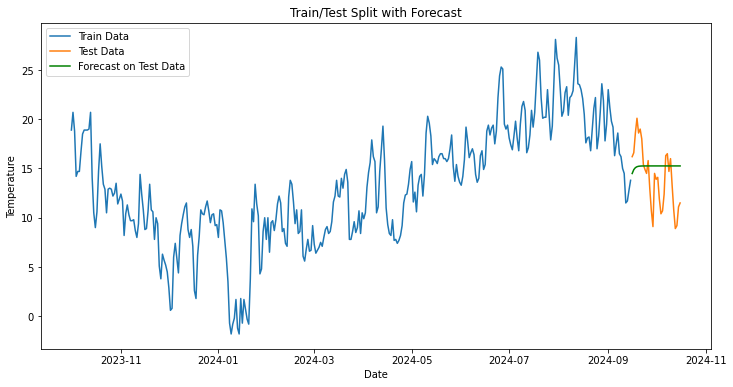

In [16]:
# Plot the ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, forecast, label='Forecast on Test Data', color='green')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Train/Test Split with Forecast')
plt.legend()
plt.show()

## Part b
### Definition and Function

*Types of Exponential Smoothing:*

* Simple Exponential Smoothing (SES)
* Holt's Linear Trend Model
* Holt-Winters Seasonal Model

1. **Simple Exponential Smoothing (SES)**:

This method is used for time series data without a trend or seasonality.

Formula:

$$ 𝑆_𝑡 = \alpha 𝑋_𝑡 + (1 - \alpha) S_{t-1}.$$

Where:

* $𝑆_𝑡$ is the smoothed statistic (forecast) at time $𝑡$
* $𝑋_𝑡$ is the actual value at time $𝑡$
* $𝑆_{𝑡−1}$ is the smoothed statistic at time ${𝑡−1}$
* $\alpha$ is the smoothing factor $(0 < 𝛼 < 1)$

2. Holt's Linear Trend Model
This method is used for data with a trend.

2.1. **Level Equation ($L_t$)**:

$$ L_t = \alpha X_t + (1- \alpha) (S_{t-1} + T_{t-1}).$$

Where: 
* $L_t$ is Level at time $t$
* $X_t$ is actual value at time $t$
* $L_{t-1}$ is level at time $t-1$
* $T_{t-1}$ is trend at time $t-1$
* $\alpha$ is level smoothing factor $(0 < \alpha < 1)$

2.2. **Trend Equation** 

$$ T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1}.$$ 

Where:

* $𝑇_𝑡$ is Trend at time $𝑡$
* $L_t$ is level at time $t$
* $\beta$ is trend smoothing factor

2.3. **Forecast Equation** 

$$ F_{t+k} = L_t + k T_t.$$

Where:

* $F_{t + k}$ is forecast for k periods ahead
* $k$ is number of periods ahead

3. Holt-Winters Seasonal Model
This method is used for data with both trend and seasonality.

3.1. **Level Model:**

$$ L_t = \alpha (X_t - S_{t-s} + (1- \alpha) (S_{t-1} + T_{t-1}).$$

Where:

* $S_{t-s}$ is seasonal component at time $t-s$

3.2. **Trend Equation:**

$$ T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1}.$$

3.3. **Seasonal Equation:**

$$ S_t = \gamma (X_t - L_t) + (1-\gamma) S_{t-s}.$$

Where: 

* $\gamma$ is Seasonal smoothing factor

3.4. **Forecast Equation:**

$$ F_{t+k} = L_t + k T_t + S_{t-s+k}.$$

Summary
Simple Exponential Smoothing is for data without trend or seasonality.

Holt's Linear Trend Model is for data with a trend.

Holt-Winters Seasonal Model is for data with trend and seasonality, either additive or multiplicative.

### Applying Code

In [17]:
# Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

es_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit() 
es_forecast = es_model.forecast(len(test))

rmse_es = root_mean_squared_error(test, es_forecast) 
r2_es = r2_score(test, es_forecast) 
mape_es = mean_absolute_percentage_error(test, es_forecast) 
aic_es = es_model.aic 
bic_es = es_model.bic 

# Compare results 
print(f"ARIMA: RMSE={rmse_arima}, R²={r2_arima}, MAPE={mape_arima},\n AIC={aic_arima}, BIC={bic_arima}\n") 
print(f"ES: RMSE={rmse_es}, R²={r2_es}, MAPE={mape_es},\n AIC={aic_es}, BIC={bic_es}\n")

ARIMA: RMSE=3.1169174486903253, R²=-0.01879326205351628, MAPE=0.20653189479701436,
 AIC=1476.24870778274, BIC=1491.680440400674

ES: RMSE=3.0783005867354873, R²=0.006294911130383607, MAPE=0.20827729799572864,
 AIC=535.5446589821815, BIC=597.3172385576354



/home/long/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


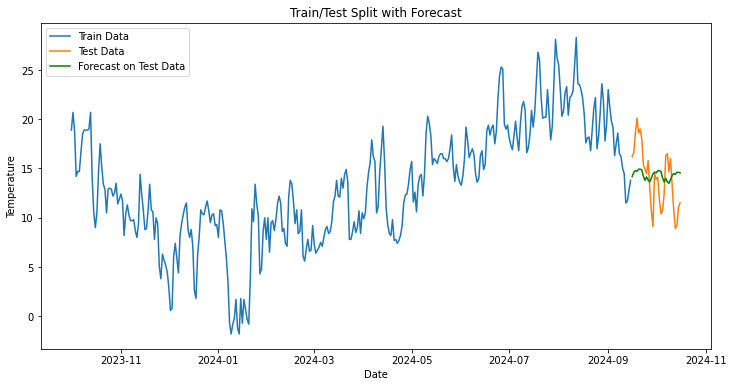

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, es_forecast, label='Forecast on Test Data', color='green')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Train/Test Split with Forecast')
plt.legend()
plt.show()

In conclution, Exponential Smoothing yields a better performance and result with positive r2 score and lower AIC score

# Question 5

In [19]:
import optuna
import lightgbm as lgb
import logging

X = df_numerical.drop(columns=['temp'])
y = target

X_train = X['2023-10-01':'2024-09-15'] 
y_train = train
X_test = X['2024-09-16':]
y_test = test

In [20]:
logging.basicConfig(level=logging.INFO)
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'root_mean_squared_error',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    # Create LightGBM datasets
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # Manual early stopping
    num_boost_round = 1000
    best_iteration = 0
    min_rmse = float('inf')
    early_stopping_rounds = 50

    for i in range(1, num_boost_round + 1):
        gbm = lgb.train(param, lgb_train, num_boost_round=i, valid_sets=[lgb_valid])
        y_pred = gbm.predict(X_test, num_iteration=i)
        rmse = root_mean_squared_error(y_test, y_pred)

        if rmse < min_rmse:
            min_rmse = rmse
            best_iteration = i
        elif i - best_iteration >= early_stopping_rounds:
            break  # Stop if no improvement for early_stopping_rounds
    
    # Save best_iteration in the study
    trial.study.set_user_attr("best_iteration", best_iteration)
    
    # Log the best iteration and corresponding RMSE
    logging.info(f"Best iteration: {best_iteration}, RMSE: {min_rmse}")
    
    return min_rmse

study = optuna.create_study(direction='minimize', study_name='LGBM Regressor Optimization')
study.optimize(objective, n_trials=10)

best_params = study.best_params
best_iteration = study.user_attrs["best_iteration"]  # Retrieve best iteration

print("Best hyperparameters:", best_params)
print("Best iteration:", best_iteration)

best_params['objective'] = 'regression'
best_params['metric'] = 'root_mean_squared_error'

final_model = lgb.train(
    best_params,
    lgb.Dataset(X_train, y_train),
    valid_sets=[lgb.Dataset(X_test, y_test)],
    num_boost_round=best_iteration  # Use the best iteration
)

y_pred_final = final_model.predict(X_test, num_iteration=best_iteration)
final_rmse = root_mean_squared_error(y_test, y_pred_final)
r2 = r2_score(y_test, y_pred_final)
mape = mean_absolute_percentage_error(y_test, y_pred_final)

print(f"Final Model Best Iteration: {best_iteration}")

# compare result
print(f"LightBGM: RMSE={final_rmse:.3f}, R2 Score={r2:.3f}, MAPE={mape:.3f}\n")
print(f"ARIMA: RMSE={rmse_arima:.3f}, R²={r2_arima:.3f}, MAPE={mape_arima:.3f}\n") 
print(f"ES: RMSE={rmse_es:.3f}, R²={r2_es:.3f}, MAPE={mape_es:.3f}\n")

[I 2024-11-22 22:02:20,823] A new study created in memory with name: LGBM Regressor Optimization
/tmp/ipykernel_1366713/2648036422.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_1366713/2648036422.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_1366713/2648036422.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_

Best hyperparameters: {'lambda_l1': 3.131396229155669e-05, 'lambda_l2': 0.0011905990268624037, 'num_leaves': 112, 'learning_rate': 0.02611132426695351, 'max_depth': 4, 'feature_fraction': 0.8099786920214753, 'bagging_fraction': 0.9645211059776377, 'bagging_freq': 7, 'min_child_samples': 9}
Best iteration: 322
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1663
[LightGBM] [Info] Number of data points in the train set: 351, number of used features: 22
[LightGBM] [Info] Start training from score 13.207977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [21]:
final_model.save_model('./models/lightbgm2.pth')

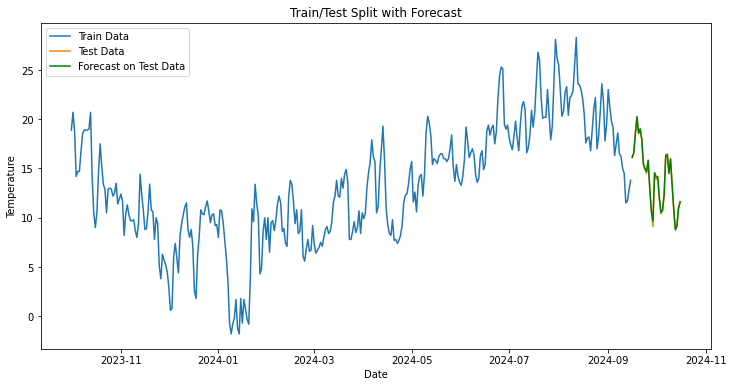

In [22]:
# Plot the LightBGM prediction
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Train Data')
plt.plot(y_test, label='Test Data')
plt.plot(test.index, y_pred_final, label='Forecast on Test Data', color='green')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Train/Test Split with Forecast')
plt.legend()
plt.show()

Model LightBGM yeild a better performance than ARIMA and ES with r2_score at 0.801. Considering overfitting problem

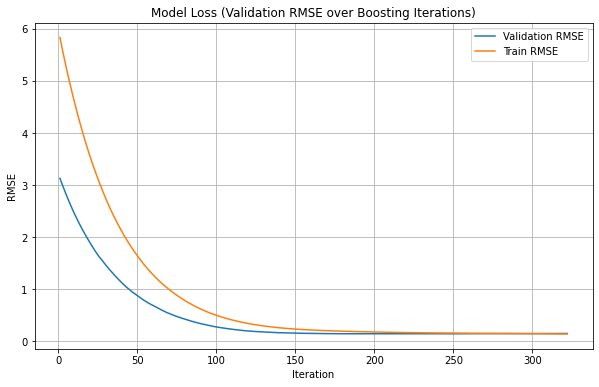

In [23]:
validation_loss = []
train_loss = []
for i in range(1, best_iteration + 1):
    y_pred_partial = final_model.predict(X_test, num_iteration=i)
    rmse_partial = root_mean_squared_error(y_test, y_pred_partial)
    y_pred_train = final_model.predict(X_train, num_iteration=i)
    rmse_y_train = root_mean_squared_error(y_train, y_pred_train)
    validation_loss.append(rmse_partial)
    train_loss.append(rmse_y_train)

plt.figure(figsize=(10, 6))
plt.plot(range(1, best_iteration + 1), validation_loss, label='Validation RMSE')
plt.plot(range(1, best_iteration + 1), train_loss, label='Train RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Model Loss (Validation RMSE over Boosting Iterations)')
plt.legend()
plt.grid(True)
plt.show()

Well-fitted

In [24]:
loaded_model = lgb.Booster(model_file='./models/lightbgm2.pth')
model_info = loaded_model.dump_model() 
print(model_info)

pred = loaded_model.predict(X_test)
r2sc = r2_score(y_test, pred)
r2sc

{'name': 'tree', 'version': 'v4', 'num_class': 1, 'num_tree_per_iteration': 1, 'label_index': 0, 'max_feature_idx': 22, 'objective': 'regression', 'average_output': False, 'feature_names': ['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase'], 'monotone_constraints': [], 'feature_infos': {'tempmax': {'min_value': -1.3, 'max_value': 36.2, 'values': []}, 'tempmin': {'min_value': -4.1, 'max_value': 21.2, 'values': []}, 'feelslikemax': {'min_value': -5.5, 'max_value': 39, 'values': []}, 'feelslikemin': {'min_value': -7.3, 'max_value': 21.2, 'values': []}, 'feelslike': {'min_value': -6.3, 'max_value': 29.6, 'values': []}, 'dew': {'min_value': -6.1, 'max_value': 20.3, 'values': []}, 'humidity': {'min_value': 51.6, 'max_value': 95, 'values': []}, 'p

0.9976192651891502

# Question 6
### Feature engineering the categorical data

In [25]:
df[categorical_features].head()

,name,preciptype,sunrise,sunset,conditions,description,icon,stations
datetime,,,,,,,,
2023-10-01,"Paris,France",rain,2023-10-01T07:49:34,2023-10-01T19:30:27,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,0715709999..."
2023-10-02,"Paris,France",NaN,2023-10-02T07:51:01,2023-10-02T19:28:21,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0715709999..."
2023-10-03,"Paris,France",rain,2023-10-03T07:52:29,2023-10-03T19:26:16,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,"07149099999,07156099999,07146099999,LFPV,07157..."
2023-10-04,"Paris,France",rain,2023-10-04T07:53:57,2023-10-04T19:24:10,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."
2023-10-05,"Paris,France",rain,2023-10-05T07:55:25,2023-10-05T19:22:06,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."


In [26]:
print(f"Number of unique values:\n{df[categorical_features].nunique()}")

Number of unique values:
name             1
preciptype       3
sunrise        382
sunset         382
conditions       8
description     31
icon             5
stations        27
dtype: int64


In [27]:
print(f"{df[categorical_features]['preciptype'].nunique()} cols of Precipation: {list(df[categorical_features]['preciptype'].unique())}")
print(f"{df[categorical_features]['conditions'].nunique()} cols of Conditions: {list(df[categorical_features]['conditions'].unique())}")
print(f"{df[categorical_features]['description'].nunique()} cols of Description: {list(df[categorical_features]['description'].unique())}")
print(f"{df[categorical_features]['icon'].nunique()} cols of Icon: {list(df[categorical_features]['icon'].unique())}")
print(f"{df[categorical_features]['stations'].nunique()} cols of Stations: {list(df[categorical_features]['stations'].unique())}")

3 cols of Precipation: ['rain', nan, 'rain,snow', 'rain,freezingrain,snow']
8 cols of Conditions: ['Rain, Partially cloudy', 'Partially cloudy', 'Clear', 'Rain, Overcast', 'Overcast', 'Snow, Rain, Overcast', 'Snow, Rain, Partially cloudy', 'Snow, Rain, Freezing Drizzle/Freezing Rain, Partially cloudy']
31 cols of Description: ['Partly cloudy throughout the day with morning rain.', 'Partly cloudy throughout the day.', 'Partly cloudy throughout the day with rain in the morning and afternoon.', 'Clear conditions throughout the day.', 'Partly cloudy throughout the day with late afternoon rain.', 'Cloudy skies throughout the day with morning rain.', 'Cloudy skies throughout the day with rain.', 'Partly cloudy throughout the day with rain.', 'Cloudy skies throughout the day with a chance of rain throughout the day.', 'Partly cloudy throughout the day with a chance of rain throughout the day.', 'Partly cloudy throughout the day with rain clearing later.', 'Partly cloudy throughout the day wit

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_categorical_processed = pd.DataFrame(columns=['Preciptype', 'Sunrise_minutes', 'Sunset_minutes', 'Daylight_duration', 'Conditions', 'Description', 'Icon'])
df_categorical_processed['Preciptype'] = df[categorical_features]['preciptype'].fillna('none')
preciptype_dummies = df_categorical_processed['Preciptype'].str.get_dummies(sep=',')
df_categorical_processed = pd.concat([df_categorical_processed, preciptype_dummies], axis=1)
df_categorical_processed['Sunrise_minutes'] = df[categorical_features]['sunrise'].str.split('T').str[1].apply(lambda x: int(x[:2])*60 + int(x[3:5]))
df_categorical_processed['Sunset_minutes'] = df[categorical_features]['sunset'].str.split('T').str[1].apply(lambda x: int(x[:2])*60 + int(x[3:5]))
df_categorical_processed['Daylight_duration'] = df_categorical_processed['Sunset_minutes'] - df_categorical_processed['Sunrise_minutes']
df_categorical_processed['Conditions'] = df[categorical_features]['conditions']
conditions_dummies = df_categorical_processed['Conditions'].str.get_dummies(sep=',')
df_categorical_processed = pd.concat([df_categorical_processed, conditions_dummies], axis=1)
df_categorical_processed['Description'] = TfidfVectorizer(max_features=100).fit_transform(df[categorical_features]['description']).toarray()
df_categorical_processed['Icon'] = df[categorical_features]['icon']
icon_dummies = df_categorical_processed['Icon'].str.get_dummies(sep=',')
df_categorical_processed = pd.concat([df_categorical_processed, icon_dummies], axis=1)
df_categorical_processed.drop(columns=['Preciptype', 'Conditions', 'Icon'], inplace=True)
df_categorical_processed

,Sunrise_minutes,Sunset_minutes,Daylight_duration,Description,freezingrain,none,rain,snow,Freezing Drizzle/Freezing Rain,Overcast,...,Clear,Overcast,Partially cloudy,Rain,Snow,clear-day,cloudy,partly-cloudy-day,rain,snow
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01,469,1170,701,0.000000,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2023-10-02,471,1168,697,0.000000,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2023-10-03,472,1166,694,0.359391,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2023-10-04,473,1164,691,0.000000,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2023-10-05,475,1162,687,0.000000,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-12,487,1146,659,0.000000,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2024-10-13,488,1144,656,0.000000,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2024-10-14,490,1142,652,0.000000,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0


# Question 7
### (a) Applying LSTM model

In [29]:
df_total = pd.concat([df_numerical, df_categorical_processed], axis =1)
X = df_total.drop(columns=['temp']).values

y = df_numerical['temp'].values

train_len = len(train_set)
X_train = X[:train_len]
X_test = X[train_len:]
y_train = y[:train_len]
y_test = y[train_len:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (351, 45), y_train shape: (351,)
X_test shape: (31, 45), y_test shape: (31,)


In [30]:
def reshape_lstm_input(X, y, n_past):
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y.reshape(-1, 1))

    X_reshaped = []
    y_reshaped = []

    for i in range(n_past, len(X)):
        X_reshaped.append(X[i - n_past:i])
        y_reshaped.append(y[i])

    return np.array(X_reshaped), np.array(y_reshaped), scaler_X, scaler_y

n_past = 1
n_features = X_train.shape[1]

X_train_reshaped, y_train_reshaped, scaler_X, scaler_y = reshape_lstm_input(X_train, y_train, n_past)
X_test_reshaped, y_test_reshaped, _, _ = reshape_lstm_input(X_test, y_test, n_past)

if X_train_reshaped is not None and X_test_reshaped is not None:
    print("X_train_reshaped shape:", X_train_reshaped.shape)
    print("y_train_reshaped shape:", y_train_reshaped.shape)
    print("X_test_reshaped shape:", X_test_reshaped.shape)
    print("y_test_reshaped shape:", y_test_reshaped.shape)

X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_reshaped, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_reshaped, dtype=torch.float32)

X_train_reshaped shape: (350, 1, 45)
y_train_reshaped shape: (350, 1)
X_test_reshaped shape: (30, 1, 45)
y_test_reshaped shape: (30, 1)


In [31]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  
        return out

We use number hidden size and number of layers based on this reference:
https://www.kaggle.com/code/syedali110/weather-prediction-using-rnn

In [32]:
input_size = X_train_tensor.shape[2]
hidden_size = 50
num_layers = 4
output_size = 1
dropout_prob = 0.1
learning_rate = 0.001
num_epochs = 200
early_stopping_patience = 15
checkpoint_path = "best_lstm_model.pth"

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True
)

best_val_loss = float('inf')
no_improvement_epochs = 0
history = {"train_loss": [], "val_loss": []}

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
 
    for i in range(len(X_train_tensor)):
        optimizer.zero_grad()
        outputs = model(X_train_tensor[i:i+1]) 
        loss = criterion(outputs, y_train_tensor[i:i+1])
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for i in range(len(X_test_tensor)):
            outputs = model(X_test_tensor[i:i+1])
            loss = criterion(outputs, y_test_tensor[i:i+1])
            epoch_val_loss += loss.item()

    train_loss = epoch_train_loss / len(X_train_tensor)
    val_loss = epoch_val_loss / len(X_test_tensor)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
  
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
   
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model saved to {checkpoint_path} with Val Loss: {best_val_loss:.4f}")
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= early_stopping_patience:
        print("Early stopping triggered.")
        break


/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200], Train Loss: 0.0440, Val Loss: 0.0852
Model saved to best_lstm_model.pth with Val Loss: 0.0852
Epoch [2/200], Train Loss: 0.0141, Val Loss: 0.0831
Model saved to best_lstm_model.pth with Val Loss: 0.0831
Epoch [3/200], Train Loss: 0.0128, Val Loss: 0.0740
Model saved to best_lstm_model.pth with Val Loss: 0.0740
Epoch [4/200], Train Loss: 0.0115, Val Loss: 0.0630
Model saved to best_lstm_model.pth with Val Loss: 0.0630
Epoch [5/200], Train Loss: 0.0091, Val Loss: 0.0534
Model saved to best_lstm_model.pth with Val Loss: 0.0534
Epoch [6/200], Train Loss: 0.0073, Val Loss: 0.0467
Model saved to best_lstm_model.pth with Val Loss: 0.0467
Epoch [7/200], Train Loss: 0.0068, Val Loss: 0.0404
Model saved to best_lstm_model.pth with Val Loss: 0.0404
Epoch [8/200], Train Loss: 0.0064, Val Loss: 0.0397
Model saved to best_lstm_model.pth with Val Loss: 0.0397
Epoch [9/200], Train Loss: 0.0062, Val Loss: 0.0385
Model saved to best_lstm_model.pth with Val Loss: 0.0385
Epoch [10/200], Tra

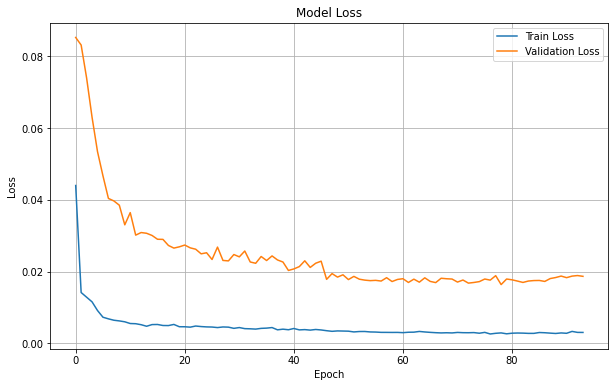

MAE: 3.0864
MSE: 14.8248
RMSE: 3.8503
R2 Score: 0.7884


In [35]:
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
plt.figure(figsize=(10, 6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.grid()
plt.show()

with torch.no_grad():
    predictions = model(X_test_tensor).numpy()
    y_test_actual = y_test_tensor.numpy()
predictions = scaler_y.inverse_transform(predictions)
y_test_actual = scaler_y.inverse_transform(y_test_actual)
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

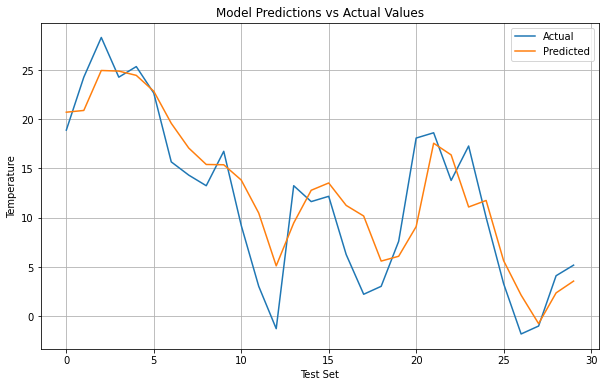

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title("Model Predictions vs Actual Values")
plt.xlabel("Test Set")
plt.ylabel("Temperature")
plt.grid()
plt.show()

In [37]:
df_categorical = df[categorical_features]
df_categorical = df_categorical.drop(['name'], axis=1)
df_categorical.head()
df_categorical.to_csv("paris_categorical.csv", index=True)

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, r2_score

class LSTMWrapper(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        output_size,
        dropout_prob,
        learning_rate,
        num_epochs,
        early_stopping_patience,
        checkpoint_path
    ):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout_prob = dropout_prob
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.early_stopping_patience = early_stopping_patience
        self.checkpoint_path = checkpoint_path

        self.model = None
        self.optimizer = None
        self.scheduler = None
        self.criterion = nn.MSELoss()
    
    def fit(self, X_train, y_train, X_test, y_test):


        self.model = LSTMModel(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            output_size = self.output_size,
            dropout_prob = self.dropout_prob
        )
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
          self.optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True
        )
        best_val_loss = float('inf')
        no_improvement_epochs = 0
        history = {"train_loss": [], "val_loss": []}

        for epoch in range(self.num_epochs):
            # Training
            self.model.train()
            epoch_train_loss = 0.0

            for i in range(len(X_train)):
                self.optimizer.zero_grad()
                outputs = self.model(X_train[i:i+1])
                loss = self.criterion(outputs, y_train[i:i+1])
                loss.backward()
                self.optimizer.step()
                epoch_train_loss += loss.item()

            self.model.eval()
            epoch_val_loss = 0.0
            with torch.inference_mode():
                for i in range(len(X_test)):
                    outputs = self.model(X_test[i:i+1])
                    loss = self.criterion(outputs, y_test[i:i+1])
                    epoch_val_loss += loss.item()

            train_loss = epoch_train_loss / len(X_train)
            val_loss = epoch_val_loss / len(X_test)
            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)

            print(f"Model {self.checkpoint_path} | Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            self.scheduler.step(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improvement_epochs = 0
                torch.save(self.model.state_dict(), self.checkpoint_path)
                print(f"Model saved to {self.checkpoint_path} with Val Loss: {best_val_loss:.4f}")
            else:
                no_improvement_epochs += 1
            if no_improvement_epochs >= self.early_stopping_patience:
                print("Early stopping triggered.")
                break
        return self

    def predict(self, X):
        self.model.load_state_dict(torch.load(self.checkpoint_path))
        self.model.eval()
        with torch.inference_mode():
            return self.model(X).numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        r2 = r2_score(y, y_pred)
        return r2

In [40]:
from itertools import product
from sklearn.metrics import mean_squared_error

hidden_size = [20, 40, 80, 160]
num_layers = [2, 4, 8, 16]
param_grid = list(product(hidden_size, num_layers))

best_params = None
best_val_loss = float('inf')

results = []

for hidden_size, num_layers in param_grid:
    print(f"Training with hidden_size={hidden_size}, num_layers={num_layers}")
    model = LSTMWrapper(
        input_size=X_train_tensor.shape[2],
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=1,
        dropout_prob=0.1,
        learning_rate=0.001,
        num_epochs=200,
        early_stopping_patience=15,
        checkpoint_path=f"./models/{num_layers}_layer_{hidden_size}_neurons.pth"
    )

    model.fit(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)
    train_preds = model.predict(X_train_tensor)
    test_preds = model.predict(X_test_tensor)
    train_loss = mean_squared_error(y_train_tensor, train_preds)
    test_loss = mean_squared_error(y_test_tensor, test_preds)
    rmse = np.sqrt(test_loss)
    r2 = r2_score(y_test_tensor, test_preds)

    results.append({
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'RMSE': rmse,
        'R2': r2
    })

    print(f"Results: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        best_params = (hidden_size, num_layers)

print("\nBest Parameters:", best_params)

Training with hidden_size=20, num_layers=2
Model ./models/2_layer_20_neurons.pth | Epoch [1/200], Train Loss: 0.0199, Val Loss: 0.0708
Model saved to ./models/2_layer_20_neurons.pth with Val Loss: 0.0708
Model ./models/2_layer_20_neurons.pth | Epoch [2/200], Train Loss: 0.0101, Val Loss: 0.0581
Model saved to ./models/2_layer_20_neurons.pth with Val Loss: 0.0581
Model ./models/2_layer_20_neurons.pth | Epoch [3/200], Train Loss: 0.0081, Val Loss: 0.0453
Model saved to ./models/2_layer_20_neurons.pth with Val Loss: 0.0453
Model ./models/2_layer_20_neurons.pth | Epoch [4/200], Train Loss: 0.0065, Val Loss: 0.0356
Model saved to ./models/2_layer_20_neurons.pth with Val Loss: 0.0356
Model ./models/2_layer_20_neurons.pth | Epoch [5/200], Train Loss: 0.0059, Val Loss: 0.0309
Model saved to ./models/2_layer_20_neurons.pth with Val Loss: 0.0309
Model ./models/2_layer_20_neurons.pth | Epoch [6/200], Train Loss: 0.0059, Val Loss: 0.0308
Model saved to ./models/2_layer_20_neurons.pth with Val Loss

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/4_layer_20_neurons.pth | Epoch [1/200], Train Loss: 0.0768, Val Loss: 0.0863
Model saved to ./models/4_layer_20_neurons.pth with Val Loss: 0.0863
Model ./models/4_layer_20_neurons.pth | Epoch [2/200], Train Loss: 0.0144, Val Loss: 0.0914
Model ./models/4_layer_20_neurons.pth | Epoch [3/200], Train Loss: 0.0131, Val Loss: 0.0802
Model saved to ./models/4_layer_20_neurons.pth with Val Loss: 0.0802
Model ./models/4_layer_20_neurons.pth | Epoch [4/200], Train Loss: 0.0115, Val Loss: 0.0716
Model saved to ./models/4_layer_20_neurons.pth with Val Loss: 0.0716
Model ./models/4_layer_20_neurons.pth | Epoch [5/200], Train Loss: 0.0096, Val Loss: 0.0651
Model saved to ./models/4_layer_20_neurons.pth with Val Loss: 0.0651
Model ./models/4_layer_20_neurons.pth | Epoch [6/200], Train Loss: 0.0081, Val Loss: 0.0481
Model saved to ./models/4_layer_20_neurons.pth with Val Loss: 0.0481
Model ./models/4_layer_20_neurons.pth | Epoch [7/200], Train Loss: 0.0081, Val Loss: 0.0447
Model saved

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/8_layer_20_neurons.pth | Epoch [1/200], Train Loss: 0.0551, Val Loss: 0.1007
Model saved to ./models/8_layer_20_neurons.pth with Val Loss: 0.1007
Model ./models/8_layer_20_neurons.pth | Epoch [2/200], Train Loss: 0.0158, Val Loss: 0.1041
Model ./models/8_layer_20_neurons.pth | Epoch [3/200], Train Loss: 0.0145, Val Loss: 0.1038
Model ./models/8_layer_20_neurons.pth | Epoch [4/200], Train Loss: 0.0151, Val Loss: 0.1076
Model ./models/8_layer_20_neurons.pth | Epoch [5/200], Train Loss: 0.0149, Val Loss: 0.1071
Model ./models/8_layer_20_neurons.pth | Epoch [6/200], Train Loss: 0.0145, Val Loss: 0.1077
Model ./models/8_layer_20_neurons.pth | Epoch [7/200], Train Loss: 0.0144, Val Loss: 0.1066
Model ./models/8_layer_20_neurons.pth | Epoch [8/200], Train Loss: 0.0175, Val Loss: 0.1222
Model ./models/8_layer_20_neurons.pth | Epoch [9/200], Train Loss: 0.0170, Val Loss: 0.1062
Model ./models/8_layer_20_neurons.pth | Epoch [10/200], Train Loss: 0.0157, Val Loss: 0.0832
Model save

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/16_layer_20_neurons.pth | Epoch [1/200], Train Loss: 0.0560, Val Loss: 0.0938
Model saved to ./models/16_layer_20_neurons.pth with Val Loss: 0.0938
Model ./models/16_layer_20_neurons.pth | Epoch [2/200], Train Loss: 0.0150, Val Loss: 0.1003
Model ./models/16_layer_20_neurons.pth | Epoch [3/200], Train Loss: 0.0153, Val Loss: 0.1004
Model ./models/16_layer_20_neurons.pth | Epoch [4/200], Train Loss: 0.0149, Val Loss: 0.1033
Model ./models/16_layer_20_neurons.pth | Epoch [5/200], Train Loss: 0.0145, Val Loss: 0.1097
Model ./models/16_layer_20_neurons.pth | Epoch [6/200], Train Loss: 0.0147, Val Loss: 0.1119
Model ./models/16_layer_20_neurons.pth | Epoch [7/200], Train Loss: 0.0148, Val Loss: 0.1109
Model ./models/16_layer_20_neurons.pth | Epoch [8/200], Train Loss: 0.0201, Val Loss: 0.1424
Model ./models/16_layer_20_neurons.pth | Epoch [9/200], Train Loss: 0.0207, Val Loss: 0.1464
Model ./models/16_layer_20_neurons.pth | Epoch [10/200], Train Loss: 0.0217, Val Loss: 0.1436

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/2_layer_40_neurons.pth | Epoch [1/200], Train Loss: 0.0376, Val Loss: 0.0628
Model saved to ./models/2_layer_40_neurons.pth with Val Loss: 0.0628
Model ./models/2_layer_40_neurons.pth | Epoch [2/200], Train Loss: 0.0098, Val Loss: 0.0541
Model saved to ./models/2_layer_40_neurons.pth with Val Loss: 0.0541
Model ./models/2_layer_40_neurons.pth | Epoch [3/200], Train Loss: 0.0082, Val Loss: 0.0463
Model saved to ./models/2_layer_40_neurons.pth with Val Loss: 0.0463
Model ./models/2_layer_40_neurons.pth | Epoch [4/200], Train Loss: 0.0073, Val Loss: 0.0400
Model saved to ./models/2_layer_40_neurons.pth with Val Loss: 0.0400
Model ./models/2_layer_40_neurons.pth | Epoch [5/200], Train Loss: 0.0062, Val Loss: 0.0380
Model saved to ./models/2_layer_40_neurons.pth with Val Loss: 0.0380
Model ./models/2_layer_40_neurons.pth | Epoch [6/200], Train Loss: 0.0058, Val Loss: 0.0346
Model saved to ./models/2_layer_40_neurons.pth with Val Loss: 0.0346
Model ./models/2_layer_40_neurons.

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/4_layer_40_neurons.pth | Epoch [1/200], Train Loss: 0.0506, Val Loss: 0.0778
Model saved to ./models/4_layer_40_neurons.pth with Val Loss: 0.0778
Model ./models/4_layer_40_neurons.pth | Epoch [2/200], Train Loss: 0.0147, Val Loss: 0.0844
Model ./models/4_layer_40_neurons.pth | Epoch [3/200], Train Loss: 0.0113, Val Loss: 0.0608
Model saved to ./models/4_layer_40_neurons.pth with Val Loss: 0.0608
Model ./models/4_layer_40_neurons.pth | Epoch [4/200], Train Loss: 0.0093, Val Loss: 0.0595
Model saved to ./models/4_layer_40_neurons.pth with Val Loss: 0.0595
Model ./models/4_layer_40_neurons.pth | Epoch [5/200], Train Loss: 0.0080, Val Loss: 0.0457
Model saved to ./models/4_layer_40_neurons.pth with Val Loss: 0.0457
Model ./models/4_layer_40_neurons.pth | Epoch [6/200], Train Loss: 0.0069, Val Loss: 0.0408
Model saved to ./models/4_layer_40_neurons.pth with Val Loss: 0.0408
Model ./models/4_layer_40_neurons.pth | Epoch [7/200], Train Loss: 0.0063, Val Loss: 0.0392
Model saved

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/8_layer_40_neurons.pth | Epoch [1/200], Train Loss: 0.0298, Val Loss: 0.1057
Model saved to ./models/8_layer_40_neurons.pth with Val Loss: 0.1057
Model ./models/8_layer_40_neurons.pth | Epoch [2/200], Train Loss: 0.0144, Val Loss: 0.1029
Model saved to ./models/8_layer_40_neurons.pth with Val Loss: 0.1029
Model ./models/8_layer_40_neurons.pth | Epoch [3/200], Train Loss: 0.0145, Val Loss: 0.1065
Model ./models/8_layer_40_neurons.pth | Epoch [4/200], Train Loss: 0.0145, Val Loss: 0.1069
Model ./models/8_layer_40_neurons.pth | Epoch [5/200], Train Loss: 0.0147, Val Loss: 0.1090
Model ./models/8_layer_40_neurons.pth | Epoch [6/200], Train Loss: 0.0151, Val Loss: 0.1109
Model ./models/8_layer_40_neurons.pth | Epoch [7/200], Train Loss: 0.0155, Val Loss: 0.1139
Model ./models/8_layer_40_neurons.pth | Epoch [8/200], Train Loss: 0.0160, Val Loss: 0.1162
Model ./models/8_layer_40_neurons.pth | Epoch [9/200], Train Loss: 0.0247, Val Loss: 0.1488
Model ./models/8_layer_40_neurons.

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/16_layer_40_neurons.pth | Epoch [1/200], Train Loss: 0.0262, Val Loss: 0.1019
Model saved to ./models/16_layer_40_neurons.pth with Val Loss: 0.1019
Model ./models/16_layer_40_neurons.pth | Epoch [2/200], Train Loss: 0.0143, Val Loss: 0.1041
Model ./models/16_layer_40_neurons.pth | Epoch [3/200], Train Loss: 0.0146, Val Loss: 0.1074
Model ./models/16_layer_40_neurons.pth | Epoch [4/200], Train Loss: 0.0147, Val Loss: 0.1078
Model ./models/16_layer_40_neurons.pth | Epoch [5/200], Train Loss: 0.0151, Val Loss: 0.1108
Model ./models/16_layer_40_neurons.pth | Epoch [6/200], Train Loss: 0.0156, Val Loss: 0.1150
Model ./models/16_layer_40_neurons.pth | Epoch [7/200], Train Loss: 0.0160, Val Loss: 0.1148
Model ./models/16_layer_40_neurons.pth | Epoch [8/200], Train Loss: 0.0249, Val Loss: 0.1476
Model ./models/16_layer_40_neurons.pth | Epoch [9/200], Train Loss: 0.0276, Val Loss: 0.1471
Model ./models/16_layer_40_neurons.pth | Epoch [10/200], Train Loss: 0.0294, Val Loss: 0.1442

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/2_layer_80_neurons.pth | Epoch [1/200], Train Loss: 0.0218, Val Loss: 0.0656
Model saved to ./models/2_layer_80_neurons.pth with Val Loss: 0.0656
Model ./models/2_layer_80_neurons.pth | Epoch [2/200], Train Loss: 0.0105, Val Loss: 0.0562
Model saved to ./models/2_layer_80_neurons.pth with Val Loss: 0.0562
Model ./models/2_layer_80_neurons.pth | Epoch [3/200], Train Loss: 0.0078, Val Loss: 0.0458
Model saved to ./models/2_layer_80_neurons.pth with Val Loss: 0.0458
Model ./models/2_layer_80_neurons.pth | Epoch [4/200], Train Loss: 0.0064, Val Loss: 0.0395
Model saved to ./models/2_layer_80_neurons.pth with Val Loss: 0.0395
Model ./models/2_layer_80_neurons.pth | Epoch [5/200], Train Loss: 0.0059, Val Loss: 0.0358
Model saved to ./models/2_layer_80_neurons.pth with Val Loss: 0.0358
Model ./models/2_layer_80_neurons.pth | Epoch [6/200], Train Loss: 0.0054, Val Loss: 0.0322
Model saved to ./models/2_layer_80_neurons.pth with Val Loss: 0.0322
Model ./models/2_layer_80_neurons.

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/4_layer_80_neurons.pth | Epoch [1/200], Train Loss: 0.0316, Val Loss: 0.0900
Model saved to ./models/4_layer_80_neurons.pth with Val Loss: 0.0900
Model ./models/4_layer_80_neurons.pth | Epoch [2/200], Train Loss: 0.0141, Val Loss: 0.0894
Model saved to ./models/4_layer_80_neurons.pth with Val Loss: 0.0894
Model ./models/4_layer_80_neurons.pth | Epoch [3/200], Train Loss: 0.0132, Val Loss: 0.0782
Model saved to ./models/4_layer_80_neurons.pth with Val Loss: 0.0782
Model ./models/4_layer_80_neurons.pth | Epoch [4/200], Train Loss: 0.0116, Val Loss: 0.0642
Model saved to ./models/4_layer_80_neurons.pth with Val Loss: 0.0642
Model ./models/4_layer_80_neurons.pth | Epoch [5/200], Train Loss: 0.0089, Val Loss: 0.0547
Model saved to ./models/4_layer_80_neurons.pth with Val Loss: 0.0547
Model ./models/4_layer_80_neurons.pth | Epoch [6/200], Train Loss: 0.0076, Val Loss: 0.0447
Model saved to ./models/4_layer_80_neurons.pth with Val Loss: 0.0447
Model ./models/4_layer_80_neurons.

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/8_layer_80_neurons.pth | Epoch [1/200], Train Loss: 0.0262, Val Loss: 0.0998
Model saved to ./models/8_layer_80_neurons.pth with Val Loss: 0.0998
Model ./models/8_layer_80_neurons.pth | Epoch [2/200], Train Loss: 0.0145, Val Loss: 0.0996
Model saved to ./models/8_layer_80_neurons.pth with Val Loss: 0.0996
Model ./models/8_layer_80_neurons.pth | Epoch [3/200], Train Loss: 0.0143, Val Loss: 0.1052
Model ./models/8_layer_80_neurons.pth | Epoch [4/200], Train Loss: 0.0143, Val Loss: 0.1040
Model ./models/8_layer_80_neurons.pth | Epoch [5/200], Train Loss: 0.0143, Val Loss: 0.1072
Model ./models/8_layer_80_neurons.pth | Epoch [6/200], Train Loss: 0.0145, Val Loss: 0.1086
Model ./models/8_layer_80_neurons.pth | Epoch [7/200], Train Loss: 0.0148, Val Loss: 0.1108
Model ./models/8_layer_80_neurons.pth | Epoch [8/200], Train Loss: 0.0150, Val Loss: 0.1106
Model ./models/8_layer_80_neurons.pth | Epoch [9/200], Train Loss: 0.0216, Val Loss: 0.1394
Model ./models/8_layer_80_neurons.

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/16_layer_80_neurons.pth | Epoch [1/200], Train Loss: 0.0402, Val Loss: 0.0980
Model saved to ./models/16_layer_80_neurons.pth with Val Loss: 0.0980
Model ./models/16_layer_80_neurons.pth | Epoch [2/200], Train Loss: 0.0160, Val Loss: 0.1011
Model ./models/16_layer_80_neurons.pth | Epoch [3/200], Train Loss: 0.0150, Val Loss: 0.0987
Model ./models/16_layer_80_neurons.pth | Epoch [4/200], Train Loss: 0.0146, Val Loss: 0.1020
Model ./models/16_layer_80_neurons.pth | Epoch [5/200], Train Loss: 0.0145, Val Loss: 0.1025
Model ./models/16_layer_80_neurons.pth | Epoch [6/200], Train Loss: 0.0144, Val Loss: 0.1031
Model ./models/16_layer_80_neurons.pth | Epoch [7/200], Train Loss: 0.0143, Val Loss: 0.1040
Model ./models/16_layer_80_neurons.pth | Epoch [8/200], Train Loss: 0.0165, Val Loss: 0.1254
Model ./models/16_layer_80_neurons.pth | Epoch [9/200], Train Loss: 0.0167, Val Loss: 0.1234
Model ./models/16_layer_80_neurons.pth | Epoch [10/200], Train Loss: 0.0170, Val Loss: 0.1278

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/2_layer_160_neurons.pth | Epoch [1/200], Train Loss: 0.0236, Val Loss: 0.0562
Model saved to ./models/2_layer_160_neurons.pth with Val Loss: 0.0562
Model ./models/2_layer_160_neurons.pth | Epoch [2/200], Train Loss: 0.0112, Val Loss: 0.0551
Model saved to ./models/2_layer_160_neurons.pth with Val Loss: 0.0551
Model ./models/2_layer_160_neurons.pth | Epoch [3/200], Train Loss: 0.0083, Val Loss: 0.0476
Model saved to ./models/2_layer_160_neurons.pth with Val Loss: 0.0476
Model ./models/2_layer_160_neurons.pth | Epoch [4/200], Train Loss: 0.0072, Val Loss: 0.0450
Model saved to ./models/2_layer_160_neurons.pth with Val Loss: 0.0450
Model ./models/2_layer_160_neurons.pth | Epoch [5/200], Train Loss: 0.0063, Val Loss: 0.0405
Model saved to ./models/2_layer_160_neurons.pth with Val Loss: 0.0405
Model ./models/2_layer_160_neurons.pth | Epoch [6/200], Train Loss: 0.0064, Val Loss: 0.0408
Model ./models/2_layer_160_neurons.pth | Epoch [7/200], Train Loss: 0.0059, Val Loss: 0.0385

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/4_layer_160_neurons.pth | Epoch [1/200], Train Loss: 0.0333, Val Loss: 0.0894
Model saved to ./models/4_layer_160_neurons.pth with Val Loss: 0.0894
Model ./models/4_layer_160_neurons.pth | Epoch [2/200], Train Loss: 0.0158, Val Loss: 0.0916
Model ./models/4_layer_160_neurons.pth | Epoch [3/200], Train Loss: 0.0147, Val Loss: 0.0881
Model saved to ./models/4_layer_160_neurons.pth with Val Loss: 0.0881
Model ./models/4_layer_160_neurons.pth | Epoch [4/200], Train Loss: 0.0130, Val Loss: 0.0836
Model saved to ./models/4_layer_160_neurons.pth with Val Loss: 0.0836
Model ./models/4_layer_160_neurons.pth | Epoch [5/200], Train Loss: 0.0108, Val Loss: 0.0759
Model saved to ./models/4_layer_160_neurons.pth with Val Loss: 0.0759
Model ./models/4_layer_160_neurons.pth | Epoch [6/200], Train Loss: 0.0091, Val Loss: 0.0669
Model saved to ./models/4_layer_160_neurons.pth with Val Loss: 0.0669
Model ./models/4_layer_160_neurons.pth | Epoch [7/200], Train Loss: 0.0085, Val Loss: 0.0609

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/8_layer_160_neurons.pth | Epoch [1/200], Train Loss: 0.0292, Val Loss: 0.0964
Model saved to ./models/8_layer_160_neurons.pth with Val Loss: 0.0964
Model ./models/8_layer_160_neurons.pth | Epoch [2/200], Train Loss: 0.0151, Val Loss: 0.0986
Model ./models/8_layer_160_neurons.pth | Epoch [3/200], Train Loss: 0.0147, Val Loss: 0.1022
Model ./models/8_layer_160_neurons.pth | Epoch [4/200], Train Loss: 0.0146, Val Loss: 0.1031
Model ./models/8_layer_160_neurons.pth | Epoch [5/200], Train Loss: 0.0144, Val Loss: 0.1051
Model ./models/8_layer_160_neurons.pth | Epoch [6/200], Train Loss: 0.0144, Val Loss: 0.1054
Model ./models/8_layer_160_neurons.pth | Epoch [7/200], Train Loss: 0.0145, Val Loss: 0.1069
Model ./models/8_layer_160_neurons.pth | Epoch [8/200], Train Loss: 0.0166, Val Loss: 0.1140
Model ./models/8_layer_160_neurons.pth | Epoch [9/200], Train Loss: 0.0179, Val Loss: 0.1286
Model ./models/8_layer_160_neurons.pth | Epoch [10/200], Train Loss: 0.0189, Val Loss: 0.1298

/home/long/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Model ./models/16_layer_160_neurons.pth | Epoch [1/200], Train Loss: 0.0298, Val Loss: 0.0987
Model saved to ./models/16_layer_160_neurons.pth with Val Loss: 0.0987
Model ./models/16_layer_160_neurons.pth | Epoch [2/200], Train Loss: 0.0153, Val Loss: 0.1002
Model ./models/16_layer_160_neurons.pth | Epoch [3/200], Train Loss: 0.0147, Val Loss: 0.1019
Model ./models/16_layer_160_neurons.pth | Epoch [4/200], Train Loss: 0.0148, Val Loss: 0.1029
Model ./models/16_layer_160_neurons.pth | Epoch [5/200], Train Loss: 0.0143, Val Loss: 0.1041
Model ./models/16_layer_160_neurons.pth | Epoch [6/200], Train Loss: 0.0145, Val Loss: 0.1049
Model ./models/16_layer_160_neurons.pth | Epoch [7/200], Train Loss: 0.0144, Val Loss: 0.1071
Model ./models/16_layer_160_neurons.pth | Epoch [8/200], Train Loss: 0.0167, Val Loss: 0.1171
Model ./models/16_layer_160_neurons.pth | Epoch [9/200], Train Loss: 0.0175, Val Loss: 0.1258
Model ./models/16_layer_160_neurons.pth | Epoch [10/200], Train Loss: 0.0185, Val L

In [56]:
df_results = pd.DataFrame(results)
df_results

,hidden_size,num_layers,train_loss,test_loss,RMSE,R2
0,20,2,0.004954,0.017901,0.133795,0.768503
1,20,4,0.003359,0.019084,0.138146,0.753205
2,20,8,0.004319,0.022253,0.149175,0.712224
3,20,16,0.047180,0.093794,0.306259,-0.212937
4,40,2,0.006805,0.018207,0.134933,0.764550
5,40,4,0.003900,0.017970,0.134053,0.767612
6,40,8,0.007513,0.022512,0.150041,0.708874
7,40,16,0.041013,0.083554,0.289057,-0.080511
8,80,2,0.005871,0.017665,0.132910,0.771557
9,80,4,0.003723,0.017309,0.131563,0.776164


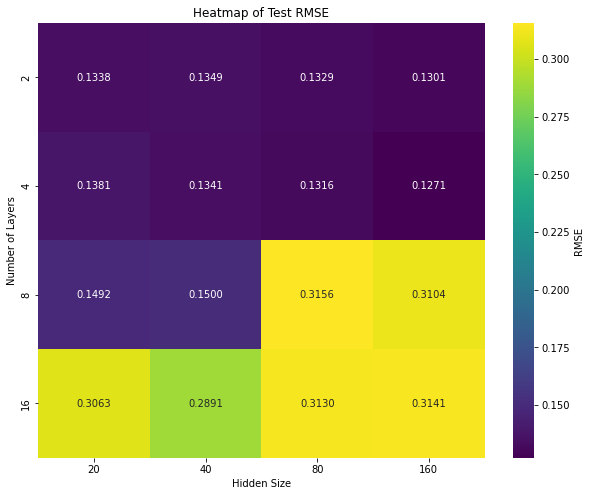

In [64]:
import seaborn as sns
heatmap_data = df_results.pivot(index='num_layers', columns='hidden_size', values='RMSE')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'RMSE'})
plt.title('Heatmap of Test RMSE')
plt.xlabel('Hidden Size')
plt.ylabel('Number of Layers')
plt.show()


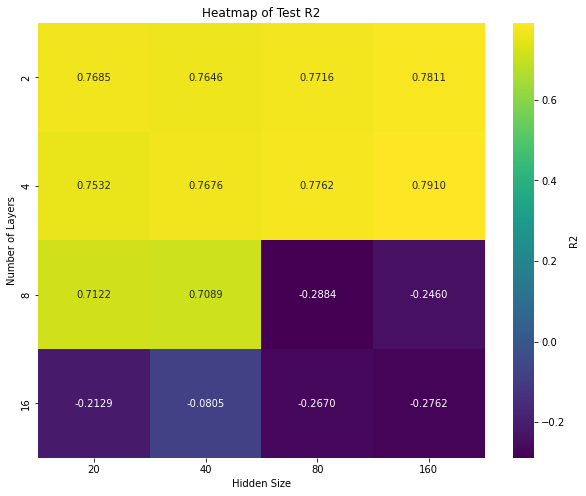

In [66]:
heatmap_data2 = df_results.pivot(index='num_layers', columns='hidden_size', values='R2')
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data2, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'R2'})
plt.title('Heatmap of Test R2')
plt.xlabel('Hidden Size')
plt.ylabel('Number of Layers')
plt.show()

As we can see, the best configuration is 160 hidden sizes and 4 layers

In [ ]:
checkpoint_path2 = r'/mnt/Data/Long-Data/time series long/models/4_layer_160_neurons.pth'